<img src="https://github.com/NeiderSmith/coin-dataset/blob/main/img.jpeg?raw=true"  width="1100px" height="400px">

# Detector de Monedas Inteligente

Este proyecto consiste en clasificar los valores que tiene las diferentes monedas Colombianas(50,100,200,500)por el sonido que ellas hagan al caer sobre una superficie(baldosa)en una determinada altura de 30cm  [Source](https://github.com/NeiderSmith/coin-dataset.git)

### Descripción del Dataset 

- 4 Tipos de monedas(50,100,200,500)
- 400 Grabaciones  (100 de cada tipo de moneda)
- Peso: 8.66MB
- Fuente: Autoría propia 

Ejemplo del Dataset: `{valormoneda}_{index}.wav` Example: `100_001.wav`


## Antes de empezar el proyecto es necesario importar las librerías necesarias para poder empezar con el proyecto, en este caso, se usarán más que todo librerías de SKLearn.


In [ ]:
import os
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import math as m
import datetime
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, mean_squared_error, accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn import model_selection
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_score

2.4.1


## Obtenemos el Dataset que usaremos para el desarrollo de nuestro proyecto; este se encuentra alojado en un repositorio de GitHub

In [ ]:
!git clone https://github.com/NeiderSmith/coin-dataset.git

Cloning into 'coin-dataset'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 709 (delta 0), reused 2 (delta 0), pack-reused 706
Receiving objects: 100% (709/709), 121.34 MiB | 36.72 MiB/s, done.


## Definición de funciones importantes
Es importante definir las funciones que serán usadas más adelante para la continuación del proyecto.

###func_padding() | get_XyData() | getXyDataMel() | show_curve()
Las tres primeras funciones definidas posteriormente nos permitiran procesar los datos del Dataset con el fin de normalizar y obtener los diferentes datos de entrada que seran enviados a diferentes clasificadores. La ultima función nombrada tendra como objetivo comparar los diferentes error que podemos obtender sobre cada clasificador para estimar la mejor configuración del mismo.

In [ ]:
def func_padding(wav, pad_size=200000):
    if wav.shape[0] > pad_size:
        return wav[0: pad_size]
    else:
        return np.hstack((wav, np.zeros(pad_size - wav.shape[0])))
        
def get_XyData(DATA_DIR = 'coin-dataset/', pad_size=200000):
  X = []
  y = []
  av_coins = ['50','100','200','500']
  for fname in os.listdir(DATA_DIR):
    struct = fname.split('_')
    digit = struct[0]
    if (digit in av_coins):
      wav, sr = librosa.load(DATA_DIR + fname)
      padded = func_padding(wav, pad_size)
      X.append(padded)
      if digit == "50":
        y.append(0)
      elif digit == "100":
        y.append(1)
      elif digit == "200":
        y.append(2)
      elif digit == "500":
        y.append(3)

  return np.vstack(X), np.array(y)

def get_XyDataMel(DATA_DIR = 'coin-dataset/', pad_size=200000):
  X = []
  y = []
  av_coins = ['50','100','200','500']
  for fname in os.listdir(DATA_DIR):
    struct = fname.split('_')
    digit = struct[0]
    if (digit in av_coins):
      wav, sr = librosa.load(DATA_DIR + fname)
      D = librosa.feature.melspectrogram(wav)
      padded = func_padding(D.reshape(D.shape[0]*D.shape[1]), pad_size)
      #padded = padded.reshape(padded.shape[0],1)
      X.append(padded)
      if digit == "50":
        y.append(0)
      elif digit == "100":
        y.append(1)
      elif digit == "200":
        y.append(2)
      elif digit == "500":
        y.append(3)

  return np.vstack(X), np.array(y)

def show_curve(est, X, y):
    means, stds = [], []
    nfolds_range = range(2,20)
    for nfolds in nfolds_range:
        #print (nfolds,)
        s = cross_val_score(est, X, y, cv=KFold(nfolds, shuffle=True), scoring=make_scorer(mean_squared_error))
        means.append(np.mean(s))
        stds.append(np.std(s))

    means = np.r_[means]
    stds  = np.r_[stds]

    plt.plot(nfolds_range, means, label="mean", color="black")
    plt.fill_between(nfolds_range, means-stds, means+stds, color="blue", alpha=.5, label="std")
    plt.xlabel("n folds")
    plt.ylabel("performance")
    plt.legend()

##Un pequeño vistazo a las muestras del dataset

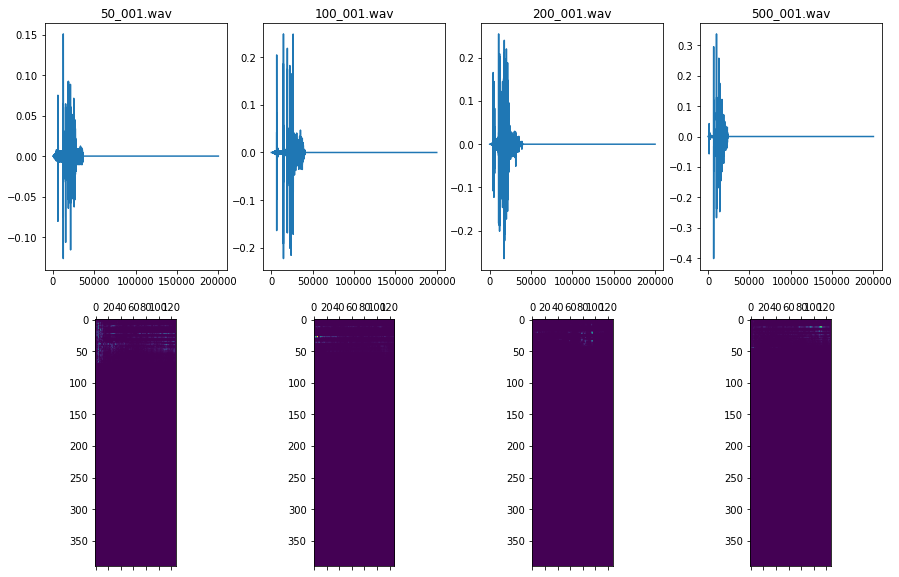

In [ ]:
file_names = ["50_001.wav","100_001.wav","200_001.wav","500_001.wav"]

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15,10))
for i in range(0,4):
  wav, sr = librosa.load('coin-dataset/' + file_names[i], sr=20000)
  padded = func_padding(wav)
  SP = librosa.feature.melspectrogram(padded)
  #print(SP.shape)
  axes[1, i].matshow(SP.T)
  axes[0, i].set_title(file_names[i])
  axes[0, i].plot(padded)

## Empezando a trabajar con el dataset
Haciendo uso de las funciones propuestas previamente se obtienen los datos de entrada procesados de dos diferentes formas, la información de la onda cruda y el melspectrogram que nos permite tener como entrada una imagen generada a partir de las muestras de sonido. Luego de obtener los datos de entrada en conjunto con sus respectivas etiquetas de clasificación, se divide el dataset y se hace el uso del 60% de las muestras del dataset para entrenamiento y el 40% restante para testeo.

In [ ]:
X, y = get_XyData()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
print("- Se escogieron " + str(y_train.shape[0]) + " para propositos de entrenamiento y " + str(y_test.shape[0]) + " para testeo usando como entrada de datos la onda cruda.")

Xmel, ymel = get_XyDataMel()
X_trainmel, X_testmel, y_trainmel, y_testmel = train_test_split(Xmel, ymel, test_size=0.4)
print("- Se escogieron " + str(y_train.shape[0]) + " para propositos de entrenamiento y " + str(y_test.shape[0]) + " para testeo usando como entrada de datos melspectrograms.")


- Se escogieron 240 para propositos de entrenamiento y 160 para testeo usando como entrada de datos la onda cruda.
- Se escogieron 240 para propositos de entrenamiento y 160 para testeo usando como entrada de datos melspectrograms.


#A continuación se implementaron diferentes tipos de clasficadores (Desicion Tree Classfier, Random Forest, Naive Bayes, Support Vector Machine)

# *** Desicion Tree Classfier ***

In [ ]:
est = DecisionTreeClassifier()
est.fit(X_train, y_train)

predictions1 = est.predict(X_train)
predictions2 = est.predict(X_test)

score1 = np.mean(predictions1 == y_train)
score2 = np.mean(predictions2 == y_test)
dtc = round(score2 * 100)

cm_train = confusion_matrix(y_train, predictions1)
cm_test = confusion_matrix(y_test, predictions2)

print("Desicion Tree Classfier")
print("Resultados obtenidos usando onda cruda de sonido como entrada:")
print("Matriz de confusión en train\n", cm_train)
print("Matriz de confusión en test\n", cm_test)

print("Puntaje para train: ", score1)
print("Puntaje para test: ", score2)


Desicion Tree Classfier
Resultados obtenidos usando onda cruda de sonido como entrada:
Matriz de confusión en train
 [[56  0  0  0]
 [ 0 50  0  0]
 [ 0  0 67  0]
 [ 0  0  0 67]]
Matriz de confusión en test
 [[24  4  3 13]
 [22 13  1 14]
 [ 0  7 18  8]
 [ 9  9  2 13]]
Puntaje para train:  1.0
Puntaje para test:  0.425


Ahora probaremos con el melspectrogram como datos de entrada ...

In [ ]:
est = DecisionTreeClassifier()
est.fit(X_trainmel, y_trainmel)

predictions1 = est.predict(X_trainmel)
predictions2 = est.predict(X_testmel)

score1 = np.mean(predictions1 == y_trainmel)
score2 = np.mean(predictions2 == y_testmel)
dtcm = round(score2 * 100)

cm_train = confusion_matrix(y_trainmel, predictions1)
cm_test = confusion_matrix(y_testmel, predictions2)

print("Desicion Tree Classfier")
print("Resultados obtenidos usando melspectrogram como entrada:")
print("Matriz de confusión en train\n", cm_train)
print("Matriz de confusión en test\n", cm_test)

print("Puntaje para train: ", score1)
print("Puntaje para test: ", score2)


Desicion Tree Classfier
Resultados obtenidos usando melspectrogram como entrada:
Matriz de confusión en train
 [[64  0  0  0]
 [ 0 58  0  0]
 [ 0  0 61  0]
 [ 0  0  0 57]]
Matriz de confusión en test
 [[16  9  7  4]
 [ 9 16  9  8]
 [ 9  8 14  8]
 [ 6 12  9 16]]
Puntaje para train:  1.0
Puntaje para test:  0.3875


# *** Random Forest ***

In [ ]:
est = RandomForestClassifier()
est.fit(X_train, y_train)

predictions1 = est.predict(X_train)
predictions2 = est.predict(X_test)

score1 = np.mean(predictions1 == y_train)
score2 = np.mean(predictions2 == y_test)
rfc = round(score2 * 100)

cm_train = confusion_matrix(y_train, predictions1)
cm_test = confusion_matrix(y_test, predictions2)

print("Random Forest")
print("Resultados obtenidos usando onda cruda de sonido como entrada:")
print("Matriz de confusión en train\n", cm_train)
print("Matriz de confusión en test\n", cm_test)

print("Puntaje para train: ", score1)
print("Puntaje para test: ", score2)



Random Forest
Resultados obtenidos usando onda cruda de sonido como entrada:
Matriz de confusión en train
 [[56  0  0  0]
 [ 0 50  0  0]
 [ 0  0 67  0]
 [ 0  0  0 67]]
Matriz de confusión en test
 [[36  4  0  4]
 [24 12  0 14]
 [ 0  0 31  2]
 [ 4  8  0 21]]
Puntaje para train:  1.0
Puntaje para test:  0.625


Ahora probaremos con el melspectrogram como datos de entrada ...

In [ ]:
est = RandomForestClassifier()
est.fit(X_trainmel, y_trainmel)

predictions1 = est.predict(X_trainmel)
predictions2 = est.predict(X_testmel)

score1 = np.mean(predictions1 == y_trainmel)
score2 = np.mean(predictions2 == y_testmel)
rfcm = round(score2 * 100)

cm_train = confusion_matrix(y_trainmel, predictions1)
cm_test = confusion_matrix(y_testmel, predictions2)

print("Random Forest")
print("Resultados obtenidos usando melspectrogram como entrada:")
print("Matriz de confusión en train\n", cm_train)
print("Matriz de confusión en test\n", cm_test)

print("Puntaje para train: ", score1)
print("Puntaje para test: ", score2)


Random Forest
Resultados obtenidos usando melspectrogram como entrada:
Matriz de confusión en train
 [[64  0  0  0]
 [ 0 58  0  0]
 [ 0  0 61  0]
 [ 0  0  0 57]]
Matriz de confusión en test
 [[32  4  0  0]
 [12 26  3  1]
 [ 2  8 20  9]
 [ 3  3 13 24]]
Puntaje para train:  1.0
Puntaje para test:  0.6375


# *** Naive Bayes  ***

In [ ]:
est = GaussianNB()
est.fit(X_train,y_train)

predictions1 = est.predict(X_train)
predictions2 = est.predict(X_test)

score1 = np.mean(predictions1 == y_train)
score2 = np.mean(predictions2 == y_test)
nb = round(score2 * 100)

cm_train = confusion_matrix(y_train, predictions1)
cm_test = confusion_matrix(y_test, predictions2)

print("Naive Bayes")
print("Resultados obtenidos usando onda cruda de sonido como entrada:")
print("Matriz de confusión en train\n", cm_train)
print("Matriz de confusión en test\n", cm_test)

print("Puntaje para train: ", score1)
print("Puntaje para test: ", score2)

Naive Bayes
Resultados obtenidos usando onda cruda de sonido como entrada:
Matriz de confusión en train
 [[55  1  0  0]
 [ 5 45  0  0]
 [ 0  0 67  0]
 [ 5 13 46  3]]
Matriz de confusión en test
 [[34  9  1  0]
 [26 17  7  0]
 [ 0  0 32  1]
 [ 4  7 21  1]]
Puntaje para train:  0.7083333333333334
Puntaje para test:  0.525


Ahora probaremos con el melspectrogram como datos de entrada ...

In [ ]:
est = GaussianNB()
est.fit(X_trainmel,y_trainmel)

predictions1 = est.predict(X_trainmel)
predictions2 = est.predict(X_testmel)

score1 = np.mean(predictions1 == y_trainmel)
score2 = np.mean(predictions2 == y_testmel)
nbm = round(score2 * 100)

cm_train = confusion_matrix(y_trainmel, predictions1)
cm_test = confusion_matrix(y_testmel, predictions2)

print("Naive Bayes")
print("Resultados obtenidos usando melspectrogram como entrada:")
print("Matriz de confusión en train\n", cm_train)
print("Matriz de confusión en test\n", cm_test)

print("Puntaje para train: ", score1)
print("Puntaje para test: ", score2)

Naive Bayes
Resultados obtenidos usando melspectrogram como entrada:
Matriz de confusión en train
 [[64  0  0  0]
 [ 0 58  0  0]
 [ 0  0 61  0]
 [ 0  0  0 57]]
Matriz de confusión en test
 [[12 14  4  6]
 [ 4 10  8 20]
 [ 0  0 32  7]
 [ 2  0 15 26]]
Puntaje para train:  1.0
Puntaje para test:  0.5


# *** Support Vector Machine ***

In [ ]:
est = SVC()
est.fit(X_train, y_train)

predictions1 = est.predict(X_train)
predictions2 = est.predict(X_test)

score1 = np.mean(predictions1 == y_train)
score2 = np.mean(predictions2 == y_test)
svm = round(score2 * 100)

cm_train = confusion_matrix(y_train, predictions1)
cm_test = confusion_matrix(y_test, predictions2)

print("Support Vector Machine")
print("Resultados obtenidos usando onda cruda de sonido como entrada:")
print("Matriz de confusión en train\n", cm_train)
print("Matriz de confusión en test\n", cm_test)

print("Puntaje para train: ", score1)
print("Puntaje para test: ", score2)

Support Vector Machine
Resultados obtenidos usando onda cruda de sonido como entrada:
Matriz de confusión en train
 [[53  0  0  3]
 [48  0  0  2]
 [ 0  0 67  0]
 [ 0  0  0 67]]
Matriz de confusión en test
 [[43  0  0  1]
 [46  0  0  4]
 [ 0  0 33  0]
 [ 1  0  0 32]]
Puntaje para train:  0.7791666666666667
Puntaje para test:  0.675


Ahora probaremos con el melspectrogram como datos de entrada ...

In [ ]:
est = SVC()
est.fit(X_trainmel, y_trainmel)

predictions1 = est.predict(X_trainmel)
predictions2 = est.predict(X_testmel)

score1 = np.mean(predictions1 == y_trainmel)
score2 = np.mean(predictions2 == y_testmel)
svmm = round(score2 * 100)

cm_train = confusion_matrix(y_trainmel, predictions1)
cm_test = confusion_matrix(y_testmel, predictions2)

print("Support Vector Machine")
print("Resultados obtenidos usando melspectrogram como entrada:")
print("Matriz de confusión en train\n", cm_train)
print("Matriz de confusión en test\n", cm_test)

print("Puntaje para train: ", score1)
print("Puntaje para test: ", score2)

Support Vector Machine
Resultados obtenidos usando melspectrogram como entrada:
Matriz de confusión en train
 [[64  0  0  0]
 [58  0  0  0]
 [ 0  0 61  0]
 [52  0  2  3]]
Matriz de confusión en test
 [[36  0  0  0]
 [42  0  0  0]
 [ 1  0 38  0]
 [37  0  6  0]]
Puntaje para train:  0.5333333333333333
Puntaje para test:  0.4625


# *** Redes Neuronales ***

##Procesamiento de labels
Las categorias de clasificación sobre los datos de entrenamiento y testeo son procesadas a caracteres de ceros y unos para disminuir el almacenamiento en memoria.


In [ ]:
y_train_ohe = tf.keras.utils.to_categorical(y_train)
y_test_ohe = tf.keras.utils.to_categorical(y_test)

y_train_ohemel = tf.keras.utils.to_categorical(y_trainmel)
y_test_ohemel = tf.keras.utils.to_categorical(y_testmel)



##Definición de la arquitectura del modelo

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten( input_shape= X_train[0].shape),
    tf.keras.layers.Dense(180, activation='relu'),      
    tf.keras.layers.Dense(4, activation='sigmoid')               
])

modelmel = tf.keras.Sequential([
    tf.keras.layers.Flatten( input_shape= X_trainmel[0].shape),
    tf.keras.layers.Dense(180, activation='relu'),      
    tf.keras.layers.Dense(4, activation='sigmoid')               
])

Escogemos el optimizador Adam, compilamos e iniciamos la etapa de entrenamiento ...

Epoch 1/5
60/60 [==============================] - 4s 19ms/step - loss: 0.6555 - accuracy: 0.3599 - val_loss: 0.5785 - val_accuracy: 0.3375
Epoch 2/5
60/60 [==============================] - 1s 12ms/step - loss: 0.2764 - accuracy: 0.9840 - val_loss: 0.5594 - val_accuracy: 0.4375
Epoch 3/5
60/60 [==============================] - 1s 12ms/step - loss: 0.1443 - accuracy: 1.0000 - val_loss: 0.5627 - val_accuracy: 0.4000
Epoch 4/5
60/60 [==============================] - 1s 12ms/step - loss: 0.0712 - accuracy: 1.0000 - val_loss: 0.5777 - val_accuracy: 0.4125
Epoch 5/5
60/60 [==============================] - 1s 12ms/step - loss: 0.0362 - accuracy: 1.0000 - val_loss: 0.5907 - val_accuracy: 0.4062


No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

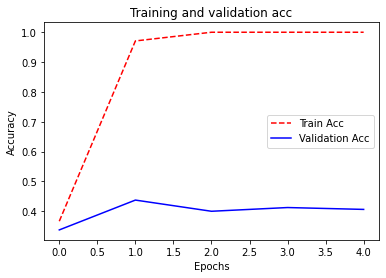

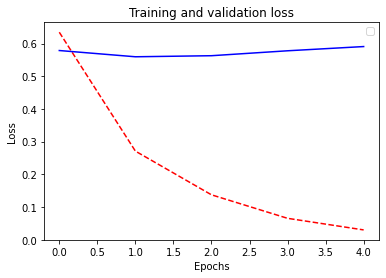

<Figure size 432x288 with 0 Axes>

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, y_train_ohe, epochs=5, batch_size=4, validation_data=(X_test, y_test_ohe))

plt.plot(history.history['accuracy'], 'r--', label='Train Acc')
plt.plot(history.history['val_accuracy'], 'b', label='Validation Acc')
plt.title ('Training and validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.figure()


plt.plot ( history.history['loss'], 'r--')
plt.plot ( history.history['val_loss'], 'b')
plt.title ('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()
plt.figure()

Ahora entrenaremos el otro modelo con el melspectrogram como datos de entrada ...

Epoch 1/5
60/60 [==============================] - 1s 15ms/step - loss: 0.5954 - accuracy: 0.3574 - val_loss: 0.5493 - val_accuracy: 0.5750
Epoch 2/5
60/60 [==============================] - 1s 12ms/step - loss: 0.2523 - accuracy: 0.9389 - val_loss: 0.8115 - val_accuracy: 0.6250
Epoch 3/5
60/60 [==============================] - 1s 12ms/step - loss: 0.1646 - accuracy: 0.9953 - val_loss: 0.9925 - val_accuracy: 0.6062
Epoch 4/5
60/60 [==============================] - 1s 12ms/step - loss: 0.0848 - accuracy: 1.0000 - val_loss: 1.3927 - val_accuracy: 0.5625
Epoch 5/5
60/60 [==============================] - 1s 12ms/step - loss: 0.0493 - accuracy: 1.0000 - val_loss: 1.6929 - val_accuracy: 0.5813


No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

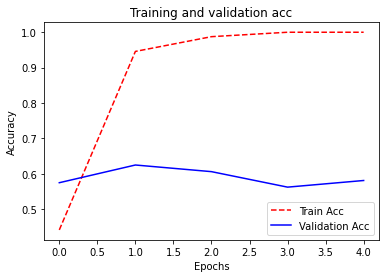

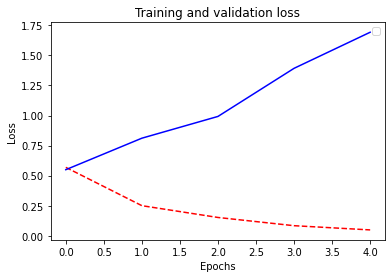

<Figure size 432x288 with 0 Axes>

In [ ]:
modelmel.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])
history = modelmel.fit(X_trainmel, y_train_ohemel, epochs=5, batch_size=4, validation_data=(X_testmel, y_test_ohemel))

plt.plot(history.history['accuracy'], 'r--', label='Train Acc')
plt.plot(history.history['val_accuracy'], 'b', label='Validation Acc')
plt.title ('Training and validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.figure()


plt.plot ( history.history['loss'], 'r--')
plt.plot ( history.history['val_loss'], 'b')
plt.title ('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()
plt.figure()

Procederemos a evaluar los modelos previamente entrenados con nuestras muestras de testeo

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test_ohe)
rn = round(test_acc * 100)

print( 'Raw -> Test acc:', test_acc, " Test_loss: ", test_loss)

5/5 [==============================] - 0s 12ms/step - loss: 0.5907 - accuracy: 0.4062
Raw -> Test acc: 0.40625  Test_loss:  0.5906745195388794


In [ ]:
test_lossmel, test_accmel = modelmel.evaluate(X_testmel, y_test_ohemel)
rnm = round(test_accmel * 100)

print( 'Melspectrogram -> Test acc:', test_accmel, " Test_loss: ", test_lossmel)

5/5 [==============================] - 0s 11ms/step - loss: 1.6929 - accuracy: 0.5813
Melspectrogram -> Test acc: 0.581250011920929  Test_loss:  1.6928670406341553


##Modificación de arquitectura del modelo; son añadidas nuevas capas ocultas.

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten( input_shape= X_train[0].shape),  
    tf.keras.layers.Dense(128, activation='relu'),      
    tf.keras.layers.Dense(128, activation='relu'),      
    tf.keras.layers.Dense(128, activation='relu'),        
    tf.keras.layers.Dense(4, activation='softmax')               
])

modelmel = tf.keras.Sequential([
    tf.keras.layers.Flatten( input_shape= X_trainmel[0].shape),  
    tf.keras.layers.Dense(128, activation='relu'),      
    tf.keras.layers.Dense(128, activation='relu'),      
    tf.keras.layers.Dense(128, activation='relu'),        
    tf.keras.layers.Dense(4, activation='softmax')               
])

Escogemos el optimizador Adam, compilamos e iniciamos la etapa de entrenamiento ...

Epoch 1/5
60/60 [==============================] - 1s 12ms/step - loss: 1.2839 - accuracy: 0.3808 - val_loss: 1.1073 - val_accuracy: 0.3500
Epoch 2/5
60/60 [==============================] - 1s 10ms/step - loss: 0.9032 - accuracy: 0.5114 - val_loss: 1.2257 - val_accuracy: 0.4313
Epoch 3/5
60/60 [==============================] - 1s 10ms/step - loss: 0.1550 - accuracy: 0.9817 - val_loss: 1.3403 - val_accuracy: 0.4625
Epoch 4/5
60/60 [==============================] - 1s 10ms/step - loss: 0.0087 - accuracy: 1.0000 - val_loss: 1.4391 - val_accuracy: 0.4437
Epoch 5/5
60/60 [==============================] - 1s 10ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 1.5064 - val_accuracy: 0.4313


No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

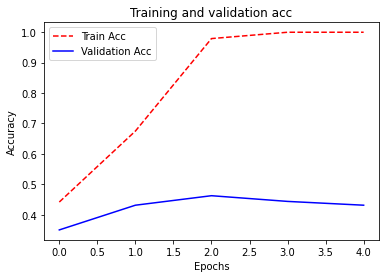

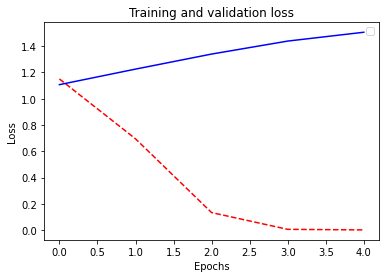

<Figure size 432x288 with 0 Axes>

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train,
          y_train_ohe,
          epochs=5,
          batch_size=4,
          validation_data=(X_test, y_test_ohe))

plt.plot(history.history['accuracy'], 'r--', label='Train Acc')
plt.plot(history.history['val_accuracy'], 'b', label='Validation Acc')
plt.title ('Training and validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.figure()


plt.plot ( history.history['loss'], 'r--')
plt.plot ( history.history['val_loss'], 'b')
plt.title ('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()
plt.figure()

Ahora entrenaremos el otro modelo con el melspectrogram como datos de entrada ...

Epoch 1/5
60/60 [==============================] - 1s 13ms/step - loss: 1.1749 - accuracy: 0.5243 - val_loss: 0.9121 - val_accuracy: 0.6500
Epoch 2/5
60/60 [==============================] - 1s 10ms/step - loss: 0.6359 - accuracy: 0.7360 - val_loss: 1.0478 - val_accuracy: 0.7188
Epoch 3/5
60/60 [==============================] - 1s 10ms/step - loss: 0.5930 - accuracy: 0.9102 - val_loss: 1.7117 - val_accuracy: 0.6625
Epoch 4/5
60/60 [==============================] - 1s 10ms/step - loss: 0.1611 - accuracy: 0.9795 - val_loss: 3.5165 - val_accuracy: 0.5562
Epoch 5/5
60/60 [==============================] - 1s 10ms/step - loss: 0.0621 - accuracy: 0.9868 - val_loss: 2.6749 - val_accuracy: 0.6313


No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

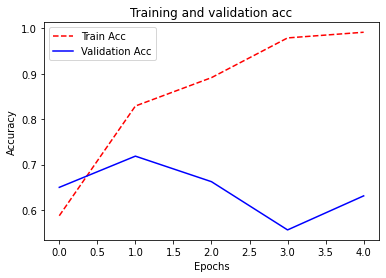

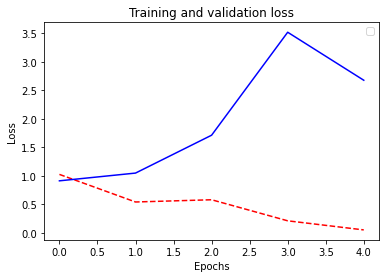

<Figure size 432x288 with 0 Axes>

In [ ]:
modelmel.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = modelmel.fit(X_trainmel,
          y_train_ohemel,
          epochs=5,
          batch_size=4,
          validation_data=(X_testmel, y_test_ohemel))

plt.plot(history.history['accuracy'], 'r--', label='Train Acc')
plt.plot(history.history['val_accuracy'], 'b', label='Validation Acc')
plt.title ('Training and validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.figure()


plt.plot ( history.history['loss'], 'r--')
plt.plot ( history.history['val_loss'], 'b')
plt.title ('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()
plt.figure()

Procederemos a evaluar los modelos previamente entrenados con nuestras muestras de testeo

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test_ohe)
rn2 = round(test_acc * 100)

print( 'Raw -> Test acc:', test_acc, " Test_loss: ", test_loss)

5/5 [==============================] - 0s 14ms/step - loss: 1.5064 - accuracy: 0.4313
Raw -> Test acc: 0.4312500059604645  Test_loss:  1.506446123123169


In [ ]:
test_lossmel, test_accmel = modelmel.evaluate(X_testmel, y_test_ohemel)
rnm2 = round(test_accmel * 100)

print( 'Melspectrogram -> Test acc:', test_accmel, " Test_loss: ", test_lossmel)

5/5 [==============================] - 0s 12ms/step - loss: 2.6749 - accuracy: 0.6313
Melspectrogram -> Test acc: 0.6312500238418579  Test_loss:  2.6749088764190674


##A continuación tenemos una comparativa entre los diferentes clasificadores propuestos ...

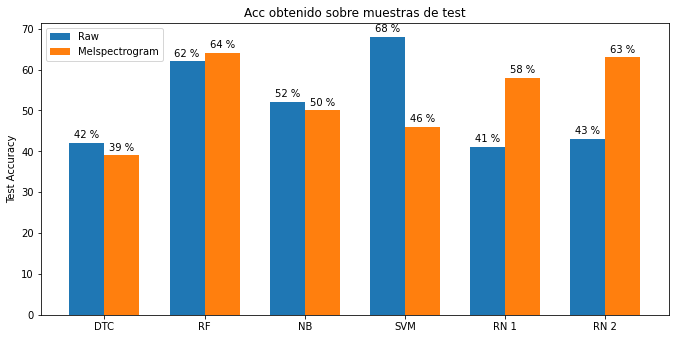

In [ ]:
labels = np.array(['DTC', 'RF', 'NB', 'SVM', 'RN 1', 'RN 2'])
y = np.array([dtc,rfc,nb,svm,rn,rn2])
ym = np.array([dtcm,rfcm,nbm,svmm,rnm,rnm2])
 
#Obtenemos la posicion de cada etiqueta en el eje de X
x = np.arange(len(labels))
#tamaño de cada barra
width = 0.35
 
fig, ax = plt.subplots()
 
#Generamos las barras para el conjunto de hombres
rects1 = ax.bar(x - width/2, y, width, label='Raw')
#Generamos las barras para el conjunto de mujeres
rects2 = ax.bar(x + width/2, ym, width, label='Melspectrogram')
 
#Añadimos las etiquetas de identificacion de valores en el grafico
ax.set_ylabel('Test Accuracy')
ax.set_title('Acc obtenido sobre muestras de test')
ax.set_xticks(x)
ax.set_xticklabels(labels)
#Añadimos un legen() esto permite mmostrar con colores a que pertence cada valor.
ax.legend()
 
def autolabel(rects):
    """Funcion para agregar una etiqueta con el valor en cada barra"""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{} %'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
 
#Añadimos las etiquetas para cada barra
autolabel(rects1)
autolabel(rects2)
fig.tight_layout()
#plt.savefig('doble_barra.png')
#Mostramos la grafica con el metodo show()
fig.set_size_inches(10, 5)

plt.show()